## Testing output from mldp implementation. 
* The experiment had first_start_day and last_start_day as 2016-01-16, a duration of 48 hours and 'daily' drifter. 
* I'm excluding one of the drifters because the corresponding model run only had a point or two and it was making the plot domain more zoomed out (it's easier to see the other drifters this way!)
* The output data is on the gpsc here: /gpfs/fs4/dfo/dpnm/dfo_dpnm/jeh326/projects/sample_test_runs_output/drifteval_mldp_ciopsw
* The runscripts are on the gpsc here: /fs/vnas_Hdfo/dpnm/jeh326/dfo-drift-projection/drift-tool/examples/sample_test_runs/drifteval/runs (I used mldpn_config_ciopsw-ex.yaml and call_drifteval_mldpn_ciopsw.sh for this particular experiment)

In [2]:
import os 
import glob
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import datetime

os.environ["PROJ_LIB"] = "C:/Users/Holdenje/Documents/R/win-library/3.5/sf/proj"
from mpl_toolkits.basemap import Basemap
%matplotlib inline

#plt.rcParams['figure.figsize'] = [12, 12]
#plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#some pd parameters
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'left')

#to set the plot size and resolution
plt.rcParams['figure.figsize'] = [16, 16]
plt.rcParams['figure.dpi'] = 200 # e.g., 100 works ok, 200 is really fine, but slower

In [11]:
# get a list of the files in the directory
def make_filelist(datadir, datatype=None, file=None):
    
    if datatype:
        datatype = '*.' + datatype
    else:
        if file == None:
            print("Must provide either a file or a datatype! Exiting.")
            exit()
    
    if file:
        filelist = [os.path.join(datadir, file)]
    else:
        filelist = []
        for file in glob.glob(os.path.join(datadir, datatype)):
            filelist.append(file)
            
    return filelist

# add all the files in the directory to one master dataframe to feed into the plotting
def create_master_dataframe(filelist):
    dfs = pd.DataFrame()

    for file in filelist:
        
        if file.split('.')[1] == "nc":
            with xr.open_dataset(file) as ds:
                vars_to_keep = ['TIME','LATITUDE','LONGITUDE']
                df_indv = ds[vars_to_keep].to_dataframe()
                df_indv['buoyid'] = 'db' + file.split('/')[-1].split('\\')[-1].split('_')[-1].split('.')[0]
                dfs = dfs.append(df_indv)
                
        elif file.split('.')[1] == "csv":
            df_indv = pd.read_csv(file)
            df_indv.rename(
                columns = {
                    'Latitude':'LATITUDE', 
                    'Longitude':'LONGITUDE', 
                    'drifter ID':'buoyid', 
                    'Date-Time (UTC)':'TIME'}, 
                inplace = True
                )
            df_indv.set_index('TIME', inplace=True)
            dfs = dfs.append(df_indv)
    
    return dfs
        
# create the plot
def plot(df, bbox=None, pcolors=None, savename=None):
    
    #convert the bbox string to a more useable format
    if bbox:
        # assumes bbox has order [lonmin latmin lonmax latmax]
        bboxvals = bbox.split(" ")
        lonmin, lonmax, latmin, latmax = float(bboxvals[0]), float(bboxvals[2]), float(bboxvals[1]), float(bboxvals[3])
        bbox_lats = [latmax, latmin, latmin, latmax, latmax]
        bbox_lons = [lonmax, lonmax, lonmin, lonmin, lonmax]
    
    all_lats = df.LATITUDE.values.tolist()
    all_lons = df.LONGITUDE.values.tolist()
    
    if bbox:
        all_lats = all_lats + bbox_lats
        all_lons = all_lons + bbox_lons
    
    drifterIDs = np.unique(df['buoyid'].values)
    
    fig, ax = plt.subplots(1,1,figsize=(15,8))
    #axisbuff = [-1, 1, -0.5, 0.5] #normal
    axisbuff = [-0.1, 0.1, -0.1, 0.1] #tight
    map = Basemap(
        projection='merc', 
        llcrnrlon=np.nanmin(all_lons)+axisbuff[0], 
        urcrnrlon=np.nanmax(all_lons)+axisbuff[1], 
        llcrnrlat=np.nanmin(all_lats)+axisbuff[2], 
        urcrnrlat=np.nanmax(all_lats)+axisbuff[3], 
        resolution='f', 
        ax=ax
        )

    map.drawcoastlines(linewidth=0.25)
    map.drawcountries(linewidth=0.25)
    #lightgray, whitesmoke, gray
    map.fillcontinents(color='whitesmoke',lake_color='white')
    map.drawmapboundary(fill_color='white')
    parallels = np.arange(-90,90,.5)
    meridians = np.arange(0,360,.5)
    map.drawparallels(parallels, labels=[False,True,True,False])
    map.drawmeridians(meridians, labels=[True,False,False,True], rotation=45)
    
    for ID in drifterIDs:
        dfuse = df[df['buoyid'] == ID]
        lats = dfuse.LATITUDE.values
        lons = dfuse.LONGITUDE.values
        x,y = map(lons, lats)
        
        if ID[:1] == 'd':
            stcolor = 'm'
            zo = 1
            linest = '-'
        elif ID[:1] == 'C':
            stcolor = 'g'
            zo = 100
            linest = '--'
        else:
            print('is there an error here?')
            exit()
            stcolor = 'g'
            zo = 1
            linest = '-'
        
        if pcolors:
            map.plot(x, y, linestyle=linest, color=pcolors[ID], zorder = zo, linewidth=1, label=ID)
            
        else:
            map.plot(x, y, linestyle=linest, zorder = zo, linewidth=1, label=ID)
            
        map.plot(x[0], y[0], color=stcolor, marker='.', zorder=300, markersize=4)

    #plot the bbox
    if bbox:
        cx, cy = map(bbox_lons, bbox_lats)
        map.plot(cx, cy, 'b--', zorder=1, linewidth=1)
        bbox_pairs = [(i, j) for i in bbox_lons for j in bbox_lats if i != j]
        for pair in bbox_pairs:
            x, y = map(pair[0], pair[1])
            map.plot(x, y, 'r.', zorder=zo, markersize=15)


    plt.legend(bbox_to_anchor=(1.05, 1))
    if savename:
        #plt.savefig(os.path.join('C:/Users/Holdenje/DRIFT/sample_drift-tool_output/mldp_implementation/', savename))
        plt.savefig(savename)
    plt.show()

## Plot the output from mldp along with the observed drifters that were used in the experiment
* I chose to ignore one drifter because the corresponding model run only had a point or two and it was making the plot domain more zoomed out (it's easier to see the other drifters this way!)
* Ignoring drifter 'db1105D20210115' (so by extension ignoring simulated drifter 'CIOPS-W_2021-01-16_drifter_11-5D20210115')
* I cropped the time to be the same for both the observed and the modelled drifters since some of the observed drifters continued on for a number of days after the 48 hours.

In [12]:
# the observed drifters
obsdir = "C:/Users/Holdenje/DRIFT/sample_drift-tool_output/mldp_implementation/obs_drifters/"
filelist_nc = make_filelist(datadir=obsdir, datatype='nc')
dfs_obs = create_master_dataframe(filelist_nc)
dfs_obs.reset_index(inplace=True)
dfs_obs = dfs_obs[~dfs_obs['buoyid'].str.contains('db1105D20210115')]
dfs_obs["TIME"] = pd.to_datetime(dfs_obs["TIME"])
time_mask_obs = (dfs_obs['TIME'].dt.day >= 16) & (dfs_obs['TIME'].dt.day <= 18) 
dfs_obs_restricted = dfs_obs[time_mask_obs]

# for the mldp simulated drifters
mldpdir = "C:/Users/Holdenje/DRIFT/sample_drift-tool_output/mldp_implementation/mldp_output/"
filelist_csv = make_filelist(datadir=mldpdir, datatype='csv')
dfs_mldp = create_master_dataframe(filelist_csv)
dfs_mldp.reset_index(inplace=True)
dfs_mldp = dfs_mldp[~dfs_mldp['buoyid'].str.contains('CIOPS-W_2021-01-16_drifter_1105D20210115')]
dfs_mldp["TIME"] = pd.to_datetime(dfs_mldp["TIME"])
time_mask_mldp = (dfs_mldp['TIME'].dt.day >= 16) & (dfs_mldp['TIME'].dt.day <= 18) 
dfs_mldp_restricted = dfs_mldp[time_mask_mldp]

# combine the two sets of drifters into one dataframe because I'm too lazy to look up how to add plots to the same basemap axis
dfs = pd.concat([dfs_obs, dfs_mldp], sort=True)
dfs.reset_index(inplace=True)

# do the same for the two sets of restricted dataframes (this is what I'll be plotting)
dfs_restricted = pd.concat([dfs_obs_restricted, dfs_mldp_restricted], sort=True)
dfs_restricted.reset_index(inplace=True)
dfs_restricted = dfs_restricted.sort_values(['buoyid','TIME'], ascending=False)

# setting similar colors for obs and simulated drifter pairs so that it's easier to see how they match up 
# (green with green, blue with blue, purple with purple)
lcolors={'CIOPS-W_2021-01-16_drifter_1110D20210115':'royalblue',
        'CIOPS-W_2021-01-16_drifter_1112D20210115':'limegreen',
        'CIOPS-W_2021-01-16_drifter_1122D20210115':'mediumorchid',
        'db1095D20210115':'yellow',
        'db1110D20210115':'navy',
        'db1112D20210115':'darkgreen',
        'db1122D20210115':'purple'}

## Making three plots:
1. obs drifters plus simulated drifters 
    * simulated drifters are the dotted lines
    * magenta dots are the starting points for the obs drifters
    * green dots are the starting points for the simulated drifters
1. simulated drifters only
1. observed drifters only

C:\Users\Holdenje\AppData\Local\conda\conda\envs\opendrift_update\lib\site-packages\ipykernel_launcher.py:78: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\Holdenje\AppData\Local\conda\conda\envs\opendrift_update\lib\site-packages\ipykernel_launcher.py:82: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


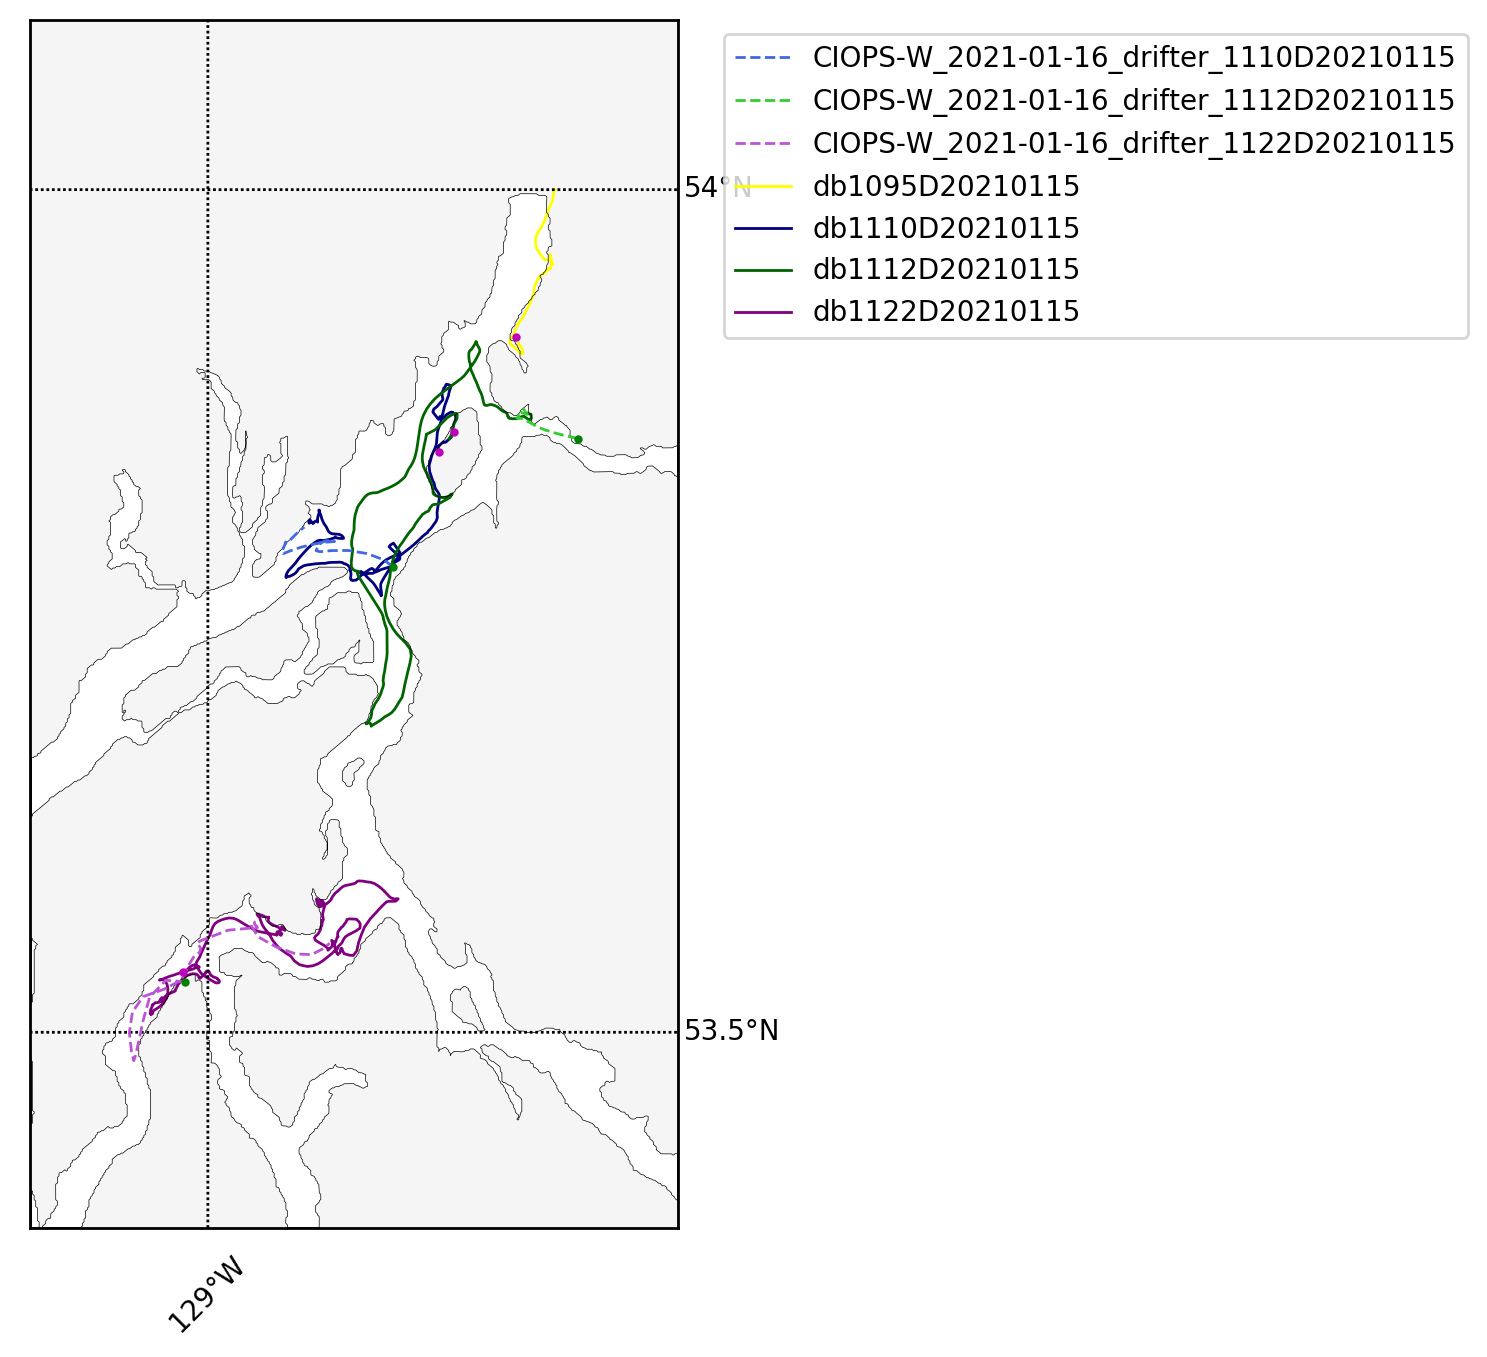

In [13]:
plot(
    dfs_restricted, 
    bbox=None, 
    pcolors=lcolors, 
    savename='C:/Users/Holdenje/DRIFT/sample_drift-tool_output/mldp_implementation/all.png'
)

C:\Users\Holdenje\AppData\Local\conda\conda\envs\opendrift_update\lib\site-packages\ipykernel_launcher.py:78: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\Holdenje\AppData\Local\conda\conda\envs\opendrift_update\lib\site-packages\ipykernel_launcher.py:82: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


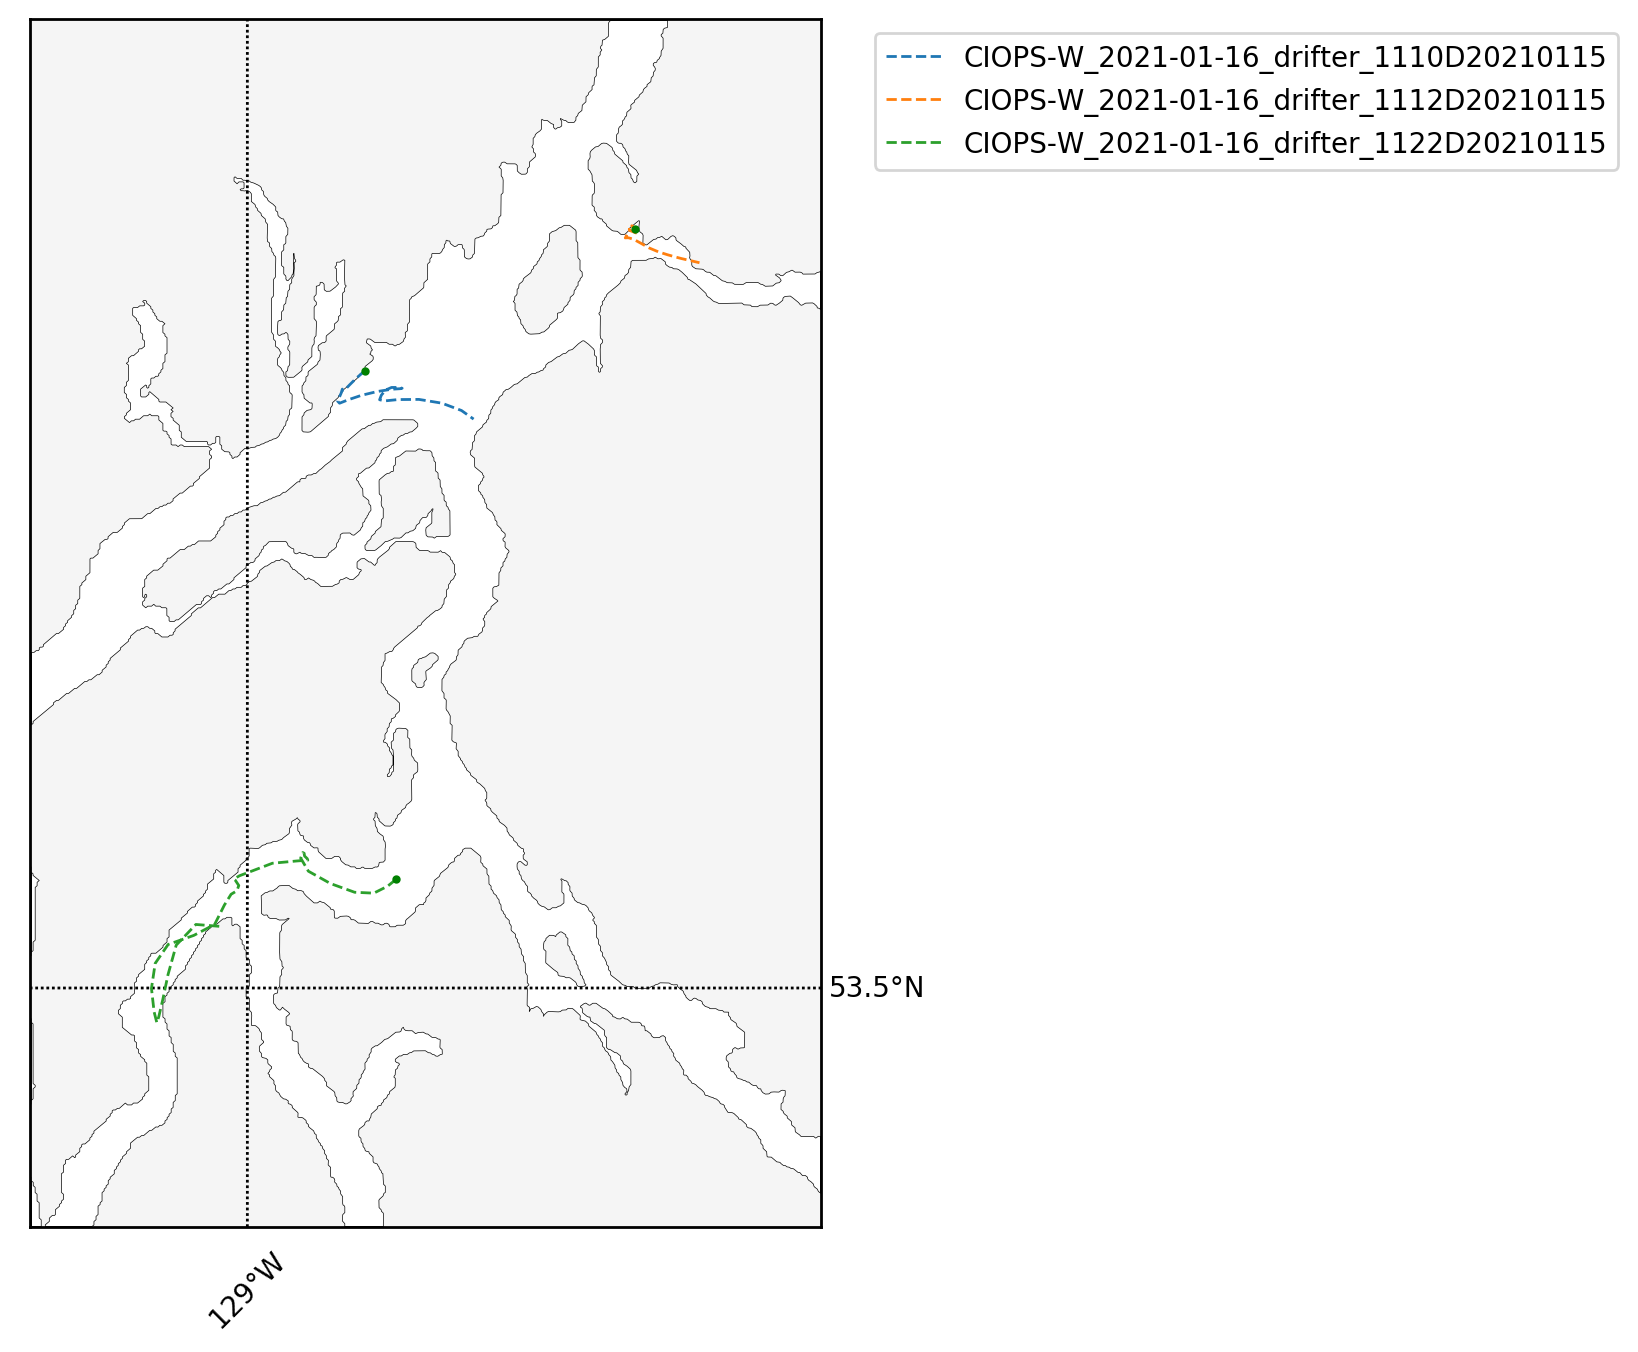

In [14]:
plot(
    dfs_mldp_restricted, 
    bbox=None, 
    savename='C:/Users/Holdenje/DRIFT/sample_drift-tool_output/mldp_implementation/mldp.png'
)

C:\Users\Holdenje\AppData\Local\conda\conda\envs\opendrift_update\lib\site-packages\ipykernel_launcher.py:78: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\Holdenje\AppData\Local\conda\conda\envs\opendrift_update\lib\site-packages\ipykernel_launcher.py:82: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


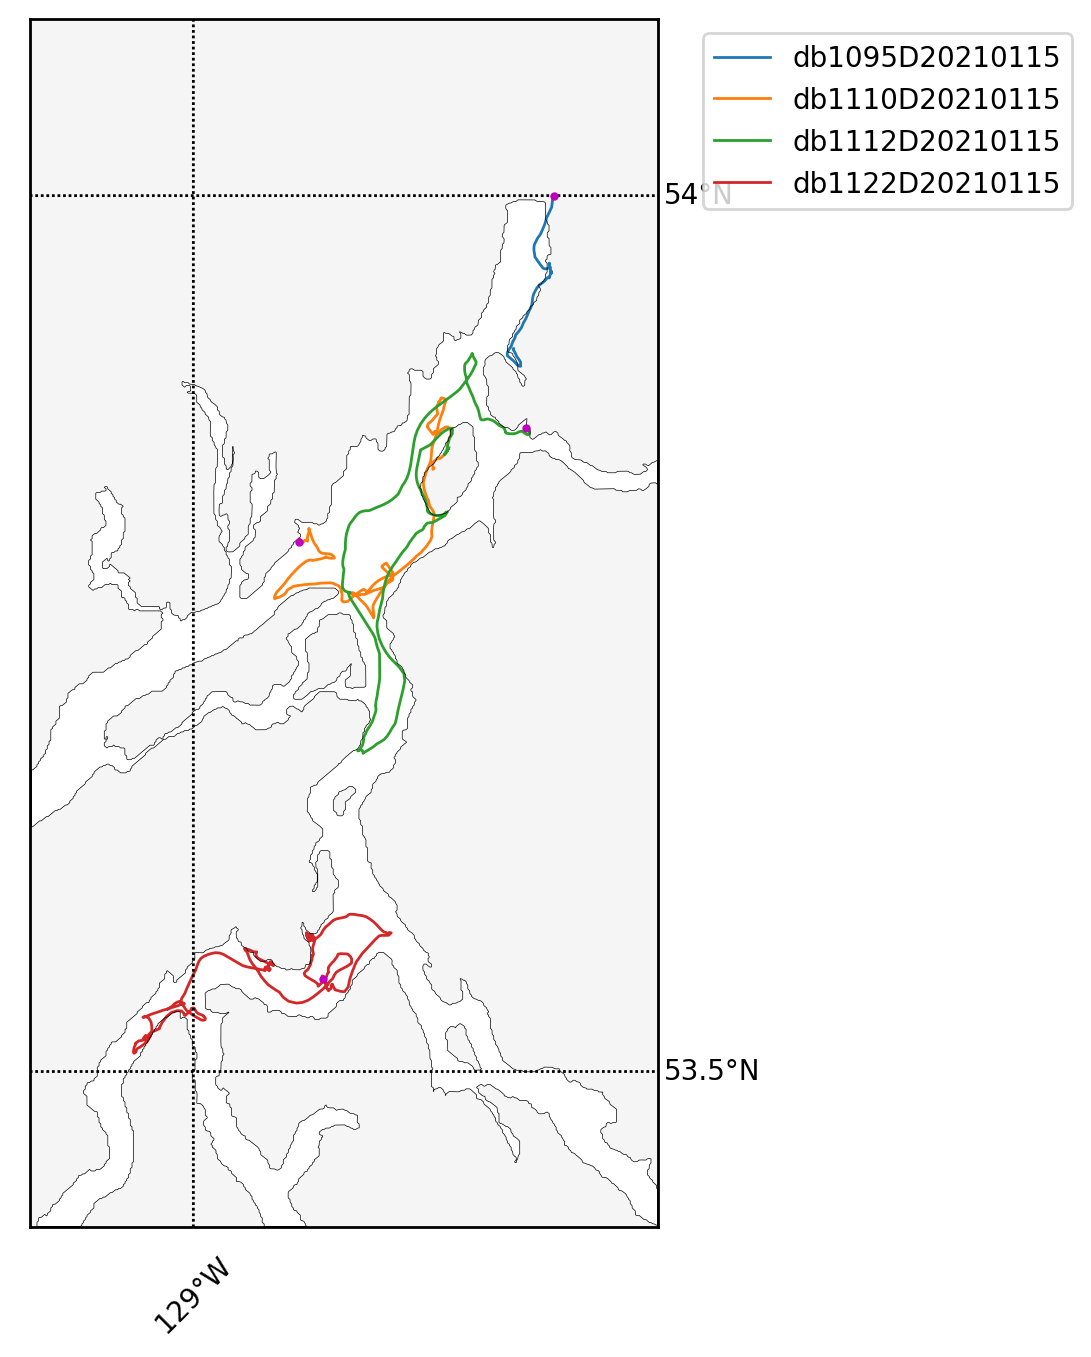

In [15]:
plot(
    dfs_obs_restricted, 
    bbox=None, 
    savename='C:/Users/Holdenje/DRIFT/sample_drift-tool_output/mldp_implementation/obs.png'
)